In [225]:
#Отключаем все возможные сообщения с различными предупреждениями:
import warnings
warnings.filterwarnings("ignore")

#Для работы с массивами и таблицами:
import numpy as np
import pandas as pd
from pandas.core.nanops import nanmean as pd_nanmean

#Для визуализаиции:
import matplotlib.pyplot as plt
import seaborn as sns
import pylab #Чтобы рисовать сразу несколько графиков в окне.

#графики в svg выглядят более четкими:
%config InlineBackend.figure_format = 'svg' 
%pylab inline


#Увеличиваем стандартный размер графиков:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5

from scipy import stats
import statsmodels.api as sm

from itertools import product
from sklearn.metrics import r2_score

Populating the interactive namespace from numpy and matplotlib


In [226]:
#Считываем обучающую и тестовую выборки в объекты DataFrame
train_data = pd.read_excel("training.xlsx").rename(columns = {'Date': 'date', 'Value': 'value'})
test_data  = pd.read_excel("testing.xlsx").rename(columns = {'Date': 'date', 'Value': 'value'})

#Приводим даты к целочисленному значению. (Образуются "отрицательные" даты - дело в том, что функция считает 0 - 1970 год)
train_data['date'] = pd.to_datetime(train_data['date']).astype(int)/ 10**10
test_data['date']  = pd.to_datetime(test_data['date']).astype(int)/ 10**10
#print (train_data.head())
test_data['date']  = (test_data['date'] - train_data['date'].mean()) / train_data['date'].std()#Нормируем по статистикам посчитанным по трейну, всё верно! Делаем "до", потому что после они изменятся.
train_data['date'] = (train_data['date'] - train_data['date'].mean()) / train_data['date'].std()
#print (train_data.head())

In [227]:
#Информация о датасетах:
print("--------------------------------")
for dataset in [train_data, test_data]: # проходим 2 frame друг за другом
    if (dataset.date[0] == train_data.date[0]):
        print("Train:\n")
    else:
        print("Test:\n")
  
    print("Amount of samples: ", dataset.shape[0])
    print("mean value: ", "%.3f" % dataset.value.mean()) # среднее арифметическое
    print("std value:  ", "%.3f" % dataset.value.std()) # среднеквадратичное (стандартное) отклонение
    print("mean date: ", "%.3f" % dataset.date.mean()) 
    print("std date:  ", "%.3f" % dataset.date.std())
    print("----------------------------------")

--------------------------------
Train:

Amount of samples:  360
mean value:  43.347
std value:   11.446
mean date:  0.000
std date:   1.000
----------------------------------
Test:

Amount of samples:  60
mean value:  65.253
std value:   1.569
mean date:  2.018
std date:   0.168
----------------------------------


        
        ВИЗУАЛИЗАЦИЯ

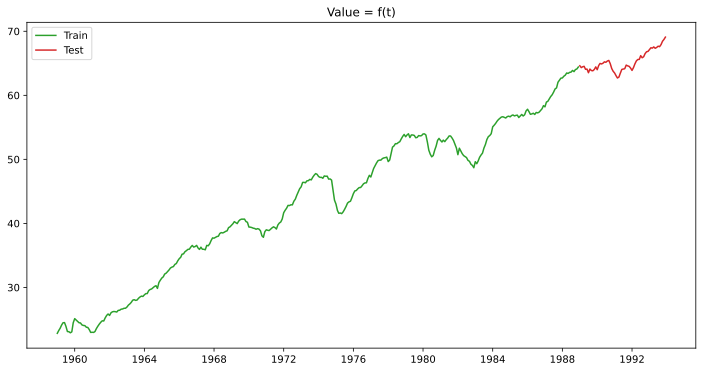

In [228]:

x_train = pd.read_excel("training.xlsx").values.copy() # np array nx2
#print (x_train[0:5]) # comment!!!!
x_test  = pd.read_excel("testing.xlsx").values.copy()
#Matplotlib.
rcParams['figure.figsize'] = 12, 6
#plt.plot('date', 'traffic', data=df, color='tab:red')
plt.plot(x_train[:,0], x_train[:,1],color='tab:green', label='Train')
plt.plot(x_test[ :,0], x_test[:,1],color='tab:red', label='Test')
plt.legend() # вот это окошко с label : test, train
plt.title("Value = f(t)")
plt.show()
#Как видим, значение value достаточно сильно коррелирует со временем.

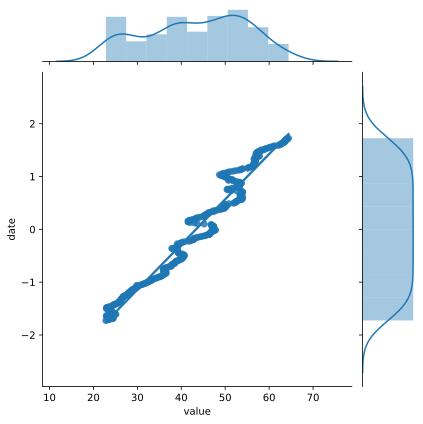

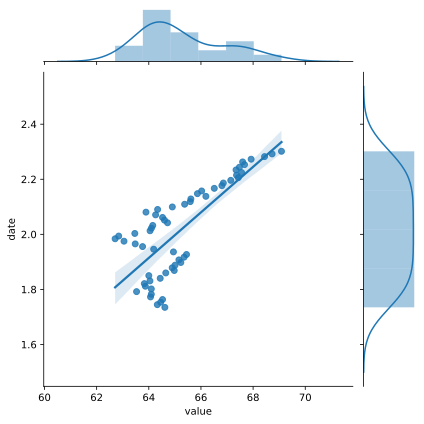

In [229]:
sns.jointplot(x ='value', y ='date', data=train_data, kind ='reg')
sns.jointplot(x ='value', y ='date', data=test_data, kind ='reg')

Средний разброс скользящего среднего:   10.8888
Средний разброс скользящего отклонения:  0.4793


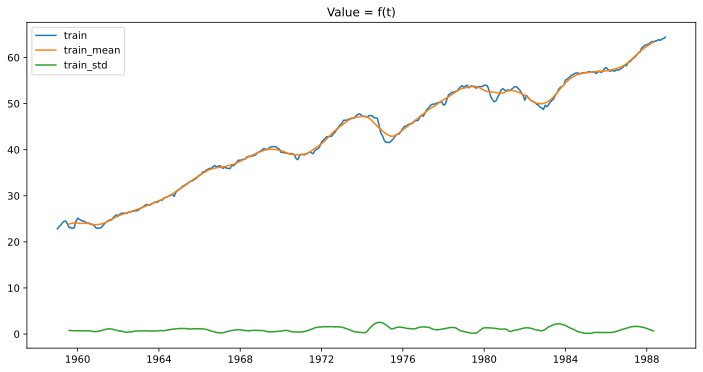

In [230]:
#Matplotlib.
rcParams['figure.figsize'] = 12, 6
window_size = 15 
plt.plot(x_train[:,0], x_train[:,1], '', label='train')
plt.plot(x_train[:,0], train_data.value.rolling(window_size, center=True).mean(), label='train_mean')
plt.plot(x_train[:,0], train_data.value.rolling(window_size, center=True).std(),  label='train_std')
plt.legend()
plt.title("Value = f(t)");
print("Средний разброс скользящего среднего:  ", "%.4f" % 
      np.std(train_data.value.rolling(window_size, center=True).mean()))
print("Средний разброс скользящего отклонения: ", "%.4f" % 
      np.std(train_data.value.rolling(window_size, center=True).std()))
plt.show()

Средний разброс скользящего среднего достаточно большой - мат.ожидание не сохраняется -> ряд нестационарный 

Средний разброс скользящего отклонения не большой - дисперсия сохраняется -> лучше дополнительно расмотреть разности 1-го порядка 

Согласно графику и вычисленной скользящей статистике наблюдаем НЕстационарность ряда.

Средний разброс скользящего среднего для разностей 1-го порядка:    0.1700
Средний разброс скользящего отклонения для разностей 1-го порядка:  0.1331


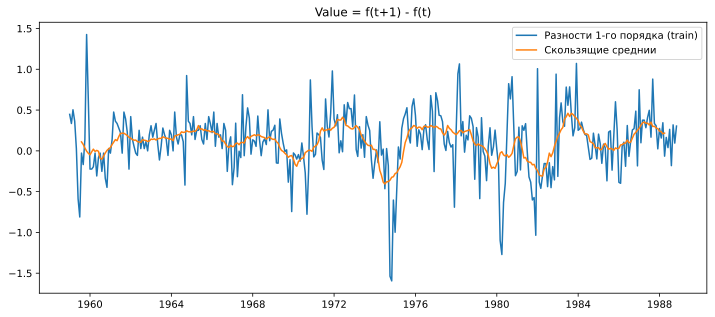

In [231]:
#Matplotlib.
rcParams['figure.figsize'] = 12, 5
ordinary_difference = train_data.value.shift(-1)-train_data.value
#print (train_data.value[0:5])
#print (ordinary_difference[0:5])
plt.plot(x_train[:,0], ordinary_difference, label='Разности 1-го порядка (train)')
plt.plot(x_train[:,0], ordinary_difference.rolling(window_size, center=True).mean(), label='Скользящие среднии')
#plt.plot(X_train[:,0], ordinary_difference.rolling(window_size, center=True).std(),  label='Скользящие отклонения')
plt.legend()
plt.title("Value = f(t+1) - f(t)");
print("Средний разброс скользящего среднего для разностей 1-го порядка:   ", 
      "%.4f" % np.std(ordinary_difference.rolling(window_size, center=True).mean()))
print("Средний разброс скользящего отклонения для разностей 1-го порядка: ", 
      "%.4f" % np.std(ordinary_difference.rolling(window_size, center=True).std()))
plt.show()

Наблюдаем стационарность разностей первого порядка данного ряда.


Класс "Полином" - апроксимирует тренд. 

Подбор параметров происходит посредством градиентного спуска. 

Непосредственно спуск по MSE (Mean Square Error).

In [232]:

class poly:
    def __init__(self, degree=1, learn_rate=0.001):
    #Задаем желаемую степень полинома и learning rate.
        self.degree = degree
        self.dim = -1 
        self.learn_rate = learn_rate 
        self.MSE = -1 
  
    def score(self):
        return self.MSE

    def fit(self, x_train, y_train, learn_rate=-1):
    #Learning rate можем менять в процессе обучения.
    #Одна итерация метода '.fit()' соответствует одной эпохе - одной "прогонке" обучающей выборке через модель.  
        if learn_rate > 0:
            self.learn_rate = learn_rate  
    #Определяем внутринние переменные при первом просмотре обучающей выборки.
        if self.dim < 0:    
            self.x_train = np.concatenate( (x_train, np.array( [[1]]*x_train.shape[0] )), axis=1 ) #dim + bias.
            self.der_matrix = np.array([[1]]*x_train.shape[0])
            for i in range(1,self.degree+1):
                self.der_matrix = np.concatenate( (x_train**i, self.der_matrix), axis=1 )
            self.der_matrix = -self.der_matrix
            self.y_train = y_train
            self.dim = self.der_matrix.shape[1] #dimension of space.
            self.parametrs = np.zeros(self.dim) # параметры нулевые
            self.grad = np.empty(self.dim) # градиент - пока из произвольных знач
            print('der_matrix: ', self.der_matrix.shape) 
            print('parametrs: ', self.parametrs.shape)

        y_pred = self.predict(x_train)
        self.MSE = ((self.y_train - y_pred)**2).sum()
        err_vect = 2*(self.y_train - y_pred).reshape(1,-1)  # reshape (<что-то>, -1) меняем размеры по <что-то> строк, а стб рассчитываютя сами (чтобы размеры соответствовали) 
    #Считаем градиент в точке и делаем соответсвенно один шаг.
        self.grad = np.dot(err_vect, self.der_matrix).reshape(-1) # dot - скалярное произведение! прикол какой питон умный
        self.parametrs -= self.learn_rate*self.grad

  #Основная функция предсказания
    def predict(self, x_test):
        x_vect = np.array([[1]]*x_test.shape[0])
        for i in range(1,self.degree+1):
            x_vect = np.concatenate( (x_test**i, x_vect), axis=1 )
        return np.sum(self.parametrs*x_vect, axis=1)


     ТЕСТИРОВАНИЕ МОДЕЛИ 


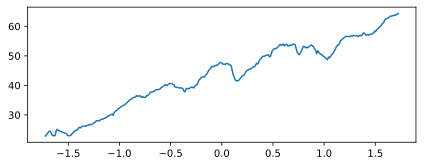

In [233]:
x_train = train_data.date.values.reshape(-1,1).copy()
y_train = train_data.value.values.copy()
rcParams['figure.figsize'] = 7, 2.5
plt.plot(x_train, y_train )

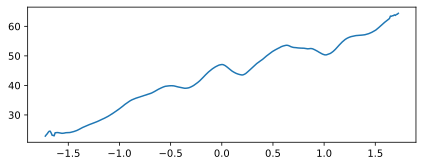

In [234]:
window_size = 20
noize = y_train - train_data.value.rolling(window_size, center=True).mean()
noize[noize.isnull()] = 0
noize = noize.values
rcParams['figure.figsize'] = 7, 2.5
plt.plot(x_train, y_train - noize);

der_matrix:  (360, 3)
parametrs:  (3,)


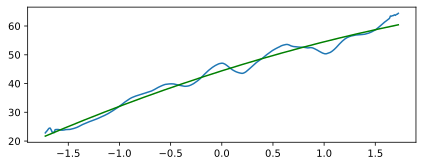

In [235]:
model = poly(degree=2, learn_rate=1e-4)
for epoch in range(50000):
    model.fit(x_train, y_train - noize)
y_pred = model.predict(x_train)
rcParams['figure.figsize'] = 7, 2.5
plt.plot(x_train, y_train - noize)
plt.plot(x_train, y_pred, 'g')
plt.show()

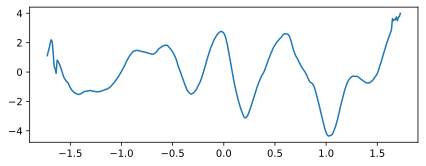

In [236]:
plt.plot(x_train, y_train - y_pred - noize, '')
plt.show()

    АДДИТИВНАЯ  МОДЕЛЬ

In [237]:

trend = model.predict(x_train)
seasonality = y_train - trend - noize
#noize
(y_train == trend + seasonality + noize).all()

True

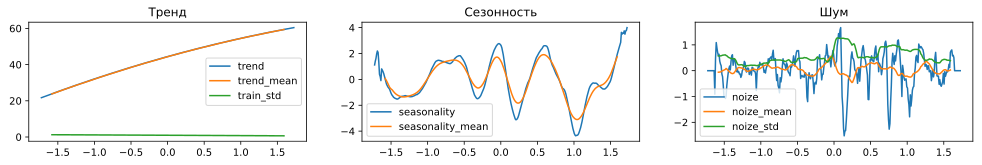

In [238]:
window_size = 30
rcParams['figure.figsize'] = 17, 2.2
pylab.subplot (1, 3, 1)
plt.plot(x_train, trend, '', label='trend')
plt.plot(x_train, pd.Series(trend).rolling(window_size, center=True).mean(), '', label='trend_mean')
plt.plot(x_train, pd.Series(trend).rolling(window_size, center=True).std(), '', label='train_std')
plt.legend()
plt.title('Тренд')

pylab.subplot (1, 3, 2)
plt.plot(x_train, seasonality, '', label='seasonality')
plt.plot(x_train, pd.Series(seasonality).rolling(window_size, center=True).mean(), '', label='seasonality_mean')
#Разкомментрировать, чтобы увидеть на графике скользящее отклонение!
#plt.plot(x_train, pd.Series(seasonality).rolling(window_size, center=True).std(), '', label='seasonality_std')
plt.legend()
plt.title('Сезонность')

pylab.subplot (1, 3, 3)
plt.plot(x_train, noize, '', label='noize')
plt.plot(x_train, pd.Series(noize).rolling(window_size, center=True).mean(), '', label='noize_mean')
plt.plot(x_train, pd.Series(noize).rolling(window_size, center=True).std(), '', label='noize_std')
plt.legend()
plt.title('Шум');

    Более привычная (наглядная) визиуализация сезонности

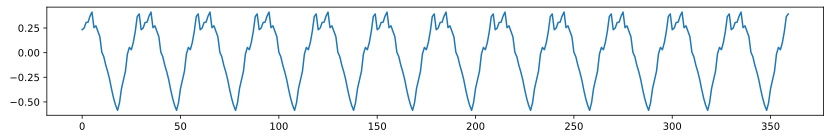

In [239]:
detrend_ = train_data.value - trend

def sesonal_mean(d, period):  # наблюдения с шагом период 0, 0+period, 1+period
    return np.array([pd_nanmean(d[i::period], axis=0) for i in range(period)])

s_a = sesonal_mean(detrend_, 30)
s_a -= np.mean(s_a, axis=0)
nobs = detrend_.shape[0]
seasonal = np.tile(s_a.T, nobs // window_size + 1).T[:nobs]

plt.figure(figsize=(14, 2))
sns.lineplot(data=seasonal)
plt.show()

    МУЛЬТИПЛИКАТИВНАЯ  МОДЕЛЬ

In [240]:

trend = model.predict(x_train)
seasonality = (y_train - noize) / trend # единственное отличие от предыдущей модели
#noize
print ("%.4f" % (y_train == trend * seasonality + noize).mean() )

0.8611


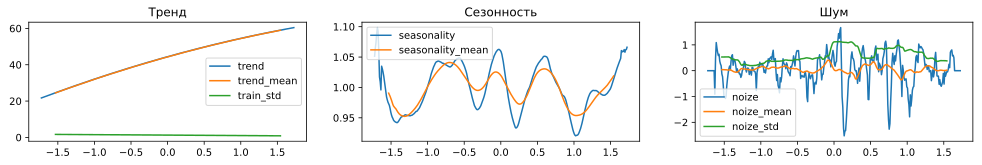

In [241]:
window_size = 40
rcParams['figure.figsize'] = 17, 2.2
pylab.subplot (1, 3, 1)
plt.plot(x_train, trend, '', label='trend')
plt.plot(x_train, pd.Series(trend).rolling(window_size, center=True).mean(), '', label='trend_mean')
plt.plot(x_train, pd.Series(trend).rolling(window_size, center=True).std(), '', label='train_std')
plt.legend()
plt.title('Тренд')

pylab.subplot (1, 3, 2)
plt.plot(x_train, seasonality, '', label='seasonality')
plt.plot(x_train, pd.Series(seasonality).rolling(window_size, center=True).mean(), '', label='seasonality_mean')
#Разкомментрировать, чтобы увидеть на графике скользящее отклонение!
#plt.plot(X_train, pd.Series(seasonality).rolling(window_size, center=True).std(), '', label='seasonality_std')   
plt.legend()
plt.title('Сезонность')

pylab.subplot (1, 3, 3)
plt.plot(x_train, noize, '', label='noize')
plt.plot(x_train, pd.Series(noize).rolling(window_size, center=True).mean(), '', label='noize_mean')
plt.plot(x_train, pd.Series(noize).rolling(window_size, center=True).std(), '', label='noize_std')
plt.legend()
plt.title('Шум');


В обеих моделях видим:
    Тренд - нестационарен
    Сезонность - стационарный ряд.
    Шум - стационарный ряд.

         
         ПОСТРОЕНИЕ ПРОГНОЗИРУЮЩЕЙ МОДЕЛИ

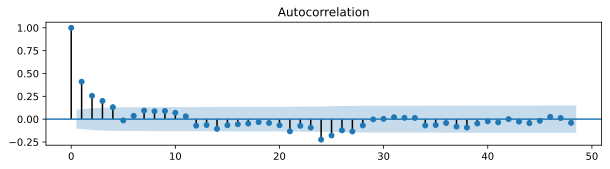

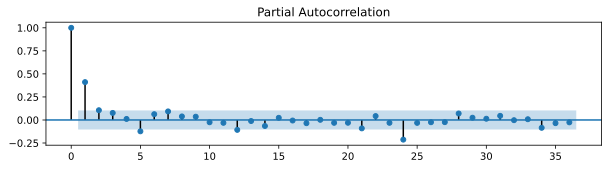

In [242]:
#Посмотрим на ACF и PACF полученного ряда:
rcParams['figure.figsize'] = 10, 5
seq = pd.read_excel('training.xlsx', index_col=0)
seq.Values = seq.Value - seq.Value.shift(1)
seq.Value.plot()
ax = plt.subplot(2,1,1)
sm.graphics.tsa.plot_acf(seq.Values[1:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(2,1,2)
sm.graphics.tsa.plot_pacf(seq.Values[1:].values.squeeze(), lags=36, ax=ax)
pylab.show()

введем следующие приближения (произвольно) Q=0, q=3, P=0, p=1

In [243]:
ps = range(0, 2) 
#ps = (0, 1)
d = 1
qs = range (0,4)
#qs = (0, 1, 2, 3)
parameters = product(ps, qs)
parameters_list = list(parameters)
print ('Кол-во параметров =', len(parameters_list))

Кол-во параметров = 8


In [244]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(seq.Value, order=(param[0], d, param[1])).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    

CPU times: user 1.3 s, sys: 4.29 ms, total: 1.3 s
Wall time: 833 ms


In [245]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print (result_table.sort_values(by = 'aic', ascending=True).head())

  parameters         aic
5     (1, 1)  255.641355
6     (1, 2)  256.958699
7     (1, 3)  258.926230
4     (1, 0)  263.241050
3     (0, 3)  266.970398


In [246]:
print('\033[1m \033[32m  BEST MODEL!')
print ('\033[0m \n', best_model.summary())

   BEST MODEL!
 
                                SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  360
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -124.821
Date:                Fri, 11 Dec 2020   AIC                            255.641
Time:                        23:03:59   BIC                            267.291
Sample:                    01-01-1959   HQIC                           260.274
                         - 12-01-1988                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7400      0.065     11.464      0.000       0.614       0.867
ma.L1         -0.3683      0.080     -4.598      0.000      -0.525      -0.211
sigma2         0.1173      0.006  

Критерий Стьюдента: p =  0.0076
Критерий Дики-Фуллера: p =  0.0000


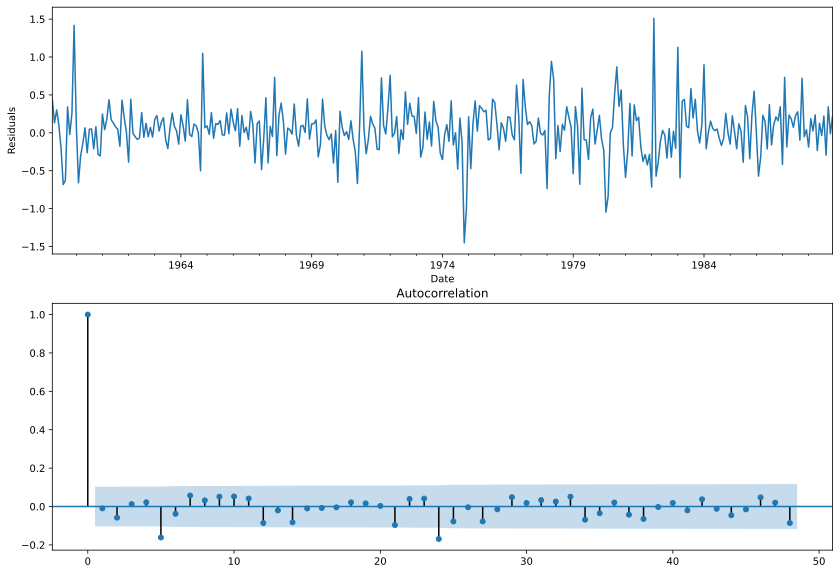

In [247]:
rcParams['figure.figsize'] = 14, 10
plt.subplot(2,1,1)
best_model.resid[1:].plot()
plt.ylabel('Residuals')
ax = plt.subplot(2,1,2)
sm.graphics.tsa.plot_acf(best_model.resid[1:].values.squeeze(), lags=48, ax=ax)
print("Критерий Стьюдента: p = ", "%.4f" % stats.ttest_1samp(best_model.resid[1:], 0)[1])
print("Критерий Дики-Фуллера: p = ", "%.4f" % sm.tsa.stattools.adfuller(best_model.resid[1:])[1])

Остатки: 
    
    несмещены (подтверждается критерием Стьюдента) 
    
    стационарны (подтверждается критерием Дики-Фуллера и визуально), 
    
    неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).

Насколько хорошо модель описывает данные?


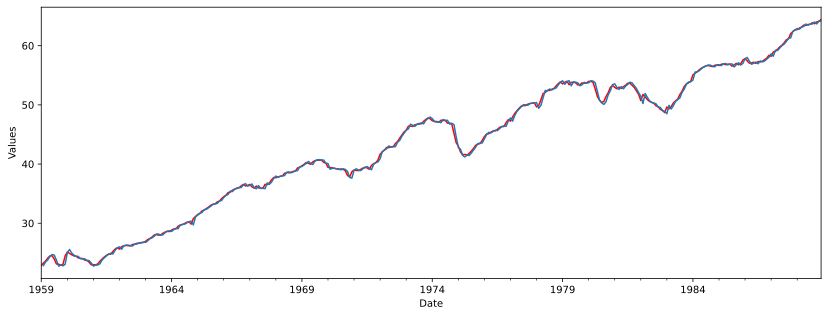

In [248]:
seq['model'] = best_model.fittedvalues
rcParams['figure.figsize'] = 14, 5
seq.Value.plot(color='r')
seq.model[1:].plot()
plt.ylabel('Values')
plt.show()
#pylab.show()


        НАШ ПРОГНОЗ

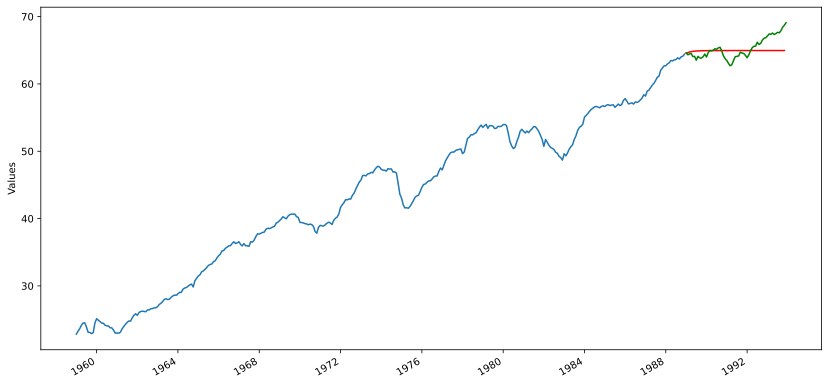

In [249]:

rcParams['figure.figsize'] = 10, 5
seq2 = seq[['Value']]
date_list = [datetime.datetime.strptime("1988-12-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,60)]
future = pd.DataFrame(index = date_list, columns = seq2.columns)
seq2 = pd.concat([seq2, future])
seq2['forecast'] = best_model.predict(start=360, end=419)

plt.figure(figsize(14,7))
seq2.Value.plot()
seq2.forecast.plot(color='r')
plt.plot(X_test[:,0],  X_test[:,1], 'g', label='Test')
plt.ylabel('Values')
pylab.show()

In [250]:
test_seq = pd.read_excel('testing.xlsx', index_col = 0)
print('на тренировочной выборке:', "%.4f" % r2_score(seq.Value, best_model.predict(start=0, end=359)))
print('на тестовой выборке:', "%.4f" % r2_score(test_seq.Value, best_model.predict(start=360, end=419)))

на тренировочной выборке: 0.9880
на тестовой выборке: -0.0245


Временной ряд является интегрированным порядка k, если его разности порядка k образуют стационарный ряд. Вернемся к вкладке "Визуализация данных" и увидим, что ряд является интегрированным порядка 1

Средний разброс скользящего среднего для разностей 1-го порядка:    0.1095
Средний разброс скользящего отклонения для разностей 1-го порядка:  0.1183


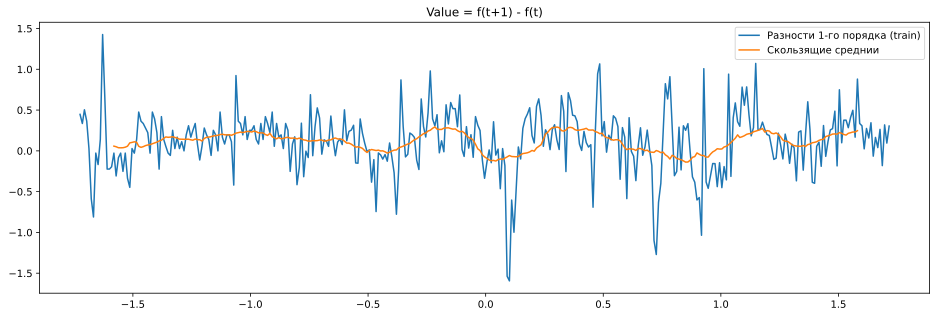

In [251]:
#Matplotlib

rcParams['figure.figsize'] = 16, 5
window_size = 30
ordinary_difference = train_data.value.shift(-1)-train_data.value
plt.plot(x_train[:,0], ordinary_difference, label='Разности 1-го порядка (train)')
plt.plot(x_train[:,0], ordinary_difference.rolling(window_size, center=True).mean(), label='Скользящие среднии')
#plt.plot(x_train[:,0], ordinary_difference.rolling(window_size, center=True).std(),  label='Скользящие отклонения')
plt.legend()
plt.title("Value = f(t+1) - f(t)");
print("Средний разброс скользящего среднего для разностей 1-го порядка:   ", 
      "%.4f" % np.std(ordinary_difference.rolling(window_size, center=True).mean()))
print("Средний разброс скользящего отклонения для разностей 1-го порядка: ", 
      "%.4f" % np.std(ordinary_difference.rolling(window_size, center=True).std()))

Наблюдаем стационарность разностей первого порядка данного ряда.